# 0. Enable GPU in Kaggle

In [1]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

CUDA Available: True
Device: Tesla T4


# 1. Environment & Determinism

In [2]:
import os, time, json, random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda")
print("Using:", torch.cuda.get_device_name(0))

Using: Tesla T4


# 2. Load Clean Metadata

In [3]:
df = pd.read_csv("/kaggle/input/datasets/saifewu/py-crackdb-clean-dataset-metadata/clean_dataset_metadata.csv")
print(df['label'].value_counts())

label
With crack       369
Without crack    200
Name: count, dtype: int64


# 3. Optimized Transforms

In [4]:
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 4. High-Performance Dataset

In [5]:
from PIL import Image

class CrackDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label_map = {"With crack": 1, "Without crack": 0}
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")
        label = self.label_map[row["label"]]
        return self.transform(img), torch.tensor(label, dtype=torch.float32)

# 5. Model Factory

In [6]:
def get_model(name):
    if name == "resnet50":
        model = models.resnet50(weights="IMAGENET1K_V1")
        model.fc = nn.Linear(model.fc.in_features, 1)

    elif name == "resnet101":
        model = models.resnet101(weights="IMAGENET1K_V1")
        model.fc = nn.Linear(model.fc.in_features, 1)

    elif name == "mobilenet_v2":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1")
        model.classifier[1] = nn.Linear(model.last_channel, 1)

    elif name == "efficientnet_b0":
        model = models.efficientnet_b0(weights="IMAGENET1K_V1")
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

    elif name == "vit_b_16":
        model = models.vit_b_16(weights="IMAGENET1K_V1")
        model.heads.head = nn.Linear(model.heads.head.in_features, 1)

    return model.to(device)

# 6. AMP Mixed Precision

In [7]:
scaler = torch.amp.GradScaler("cuda")

# 7. Training Loop

In [8]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.amp.autocast("cuda"):
            outputs = model(imgs).view(-1)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
    
    return running_loss / len(loader)

# 8. Evaluation

In [9]:
def evaluate(model, loader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)

            outputs = torch.sigmoid(model(imgs)).view(-1)

            preds.extend(outputs.cpu().numpy().tolist())
            targets.extend(labels.numpy().tolist())

    preds = np.array(preds)
    targets = np.array(targets)
    preds_bin = (preds > 0.5).astype(int)

    cm = confusion_matrix(targets, preds_bin)

    false_positives = cm[0,1]
    false_negatives = cm[1,0]

    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    return {
        "accuracy": accuracy_score(targets, preds_bin),
        "precision": precision_score(targets, preds_bin, zero_division=0),
        "recall": recall_score(targets, preds_bin, zero_division=0),
        "f1": f1_score(targets, preds_bin, zero_division=0),
        "roc_auc": roc_auc_score(targets, preds),
        "confusion_matrix": cm,
        "false_positives": false_positives,
        "false_negatives": false_negatives,
        "per_class_accuracy": per_class_acc
    }

# 9. Multi-Ratio + Early Stopping + Scheduler

In [10]:
from sklearn.model_selection import train_test_split

RATIOS = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
results = []

for ratio in RATIOS:

    train_df, test_df = train_test_split(
        df, train_size=ratio,
        stratify=df["label"], random_state=SEED
    )

    train_df, val_df = train_test_split(
        train_df, test_size=0.1,
        stratify=train_df["label"], random_state=SEED
    )

    train_loader = DataLoader(
        CrackDataset(train_df, train_transform),
        batch_size=32, shuffle=True,
        num_workers=0, pin_memory=True
    )

    val_loader = DataLoader(
        CrackDataset(val_df, val_transform),
        batch_size=32, shuffle=False,
        num_workers=0, pin_memory=True
    )

    test_loader = DataLoader(
        CrackDataset(test_df, val_transform),
        batch_size=32, shuffle=False,
        num_workers=0, pin_memory=True
    )

    for model_name in ["resnet50","resnet101",
                       "mobilenet_v2",
                       "efficientnet_b0",
                       "vit_b_16"]:

        model = get_model(model_name)
        optimizer = optim.AdamW(model.parameters(), lr=3e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
        criterion = nn.BCEWithLogitsLoss()

        best_auc = 0
        patience = 5
        counter = 0

        start_time = time.time()

        train_losses = []
        val_aucs = []
        
        for epoch in range(50):
            train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
            val_metrics = evaluate(model, val_loader)
            
            train_losses.append(train_loss)
            val_aucs.append(val_metrics["roc_auc"])
            
            scheduler.step()

            if val_metrics["roc_auc"] > best_auc:
                best_auc = val_metrics["roc_auc"]
                counter = 0
                torch.save(model.state_dict(),
                           f"/kaggle/working/{model_name}_{ratio}_best.pth")
            else:
                counter += 1
                if counter >= patience:
                    break

        train_time = time.time() - start_time

        model.load_state_dict(torch.load(
            f"/kaggle/working/{model_name}_{ratio}_best.pth"))

        learning_logs = {
            "train_loss": train_losses,
            "val_auc": val_aucs
        }

        test_metrics = evaluate(model, test_loader)
        test_metrics["model"] = model_name
        test_metrics["ratio"] = ratio
        test_metrics["train_time"] = train_time
        test_metrics["learning_logs"] = learning_logs

        results.append(test_metrics)

        torch.cuda.empty_cache()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:01<00:00, 174MB/s]


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 115MB/s] 


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 100MB/s]


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 177MB/s]


# 10. Save Structured Results

In [11]:
results_df = pd.DataFrame(results)
results_df.to_csv("/kaggle/working/task2_gpu_results.csv", index=False)
results_df.sort_values("roc_auc", ascending=False).head()

,accuracy,precision,recall,f1,roc_auc,confusion_matrix,false_positives,false_negatives,per_class_accuracy,model,ratio,train_time,learning_logs
1,0.929825,0.902439,1.000000,0.948718,1.0,"[[16, 4], [0, 37]]",4,0,"[0.8, 1.0]",resnet101,0.9,35.673450,"{'train_loss': [0.1868490976591905, 0.05567458..."
3,0.982456,1.000000,0.972973,0.986301,1.0,"[[20, 0], [1, 36]]",0,1,"[1.0, 0.972972972972973]",efficientnet_b0,0.9,38.487609,"{'train_loss': [0.36182630161444346, 0.0428164..."
2,0.982456,1.000000,0.972973,0.986301,1.0,"[[20, 0], [1, 36]]",0,1,"[1.0, 0.972972972972973]",mobilenet_v2,0.9,41.545389,"{'train_loss': [0.1575339053447048, 0.02009317..."
4,0.982456,1.000000,0.972973,0.986301,1.0,"[[20, 0], [1, 36]]",0,1,"[1.0, 0.972972972972973]",vit_b_16,0.9,68.253710,"{'train_loss': [0.6802658875783284, 0.47407106..."
5,0.991228,1.000000,0.986486,0.993197,1.0,"[[40, 0], [1, 73]]",0,1,"[1.0, 0.9864864864864865]",resnet50,0.8,25.258142,"{'train_loss': [0.17289171534447142, 0.0655290..."


In [12]:
REPORT_DIR = "/kaggle/working/task2_reports"
os.makedirs(REPORT_DIR, exist_ok=True)

# 11. Per-Class Accuracy + Confusion Matrix

In [13]:
def generate_confusion_and_class_accuracy(model, loader, model_name, ratio):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = torch.sigmoid(model(imgs)).view(-1)
            preds.extend(outputs.cpu().numpy().tolist())
            targets.extend(labels.numpy().tolist())

    preds_bin = (np.array(preds) > 0.5).astype(int)

    cm = confusion_matrix(targets, preds_bin)
    class_acc = cm.diagonal() / cm.sum(axis=1)

    print(f"\nModel: {model_name} | Ratio: {ratio}")
    print("Per-class Accuracy:")
    print(f"Without Crack: {class_acc[0]:.4f}")
    print(f"With Crack   : {class_acc[1]:.4f}")

    disp = ConfusionMatrixDisplay(cm, display_labels=["Without Crack","With Crack"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name} - Ratio {ratio}")
    plt.savefig(f"{REPORT_DIR}/cm_{model_name}_{ratio}.png")
    plt.show()
    plt.close()

    return class_acc

# 12. ROC Curve Plot

In [14]:
def generate_roc_curve(model, loader, model_name, ratio):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = torch.sigmoid(model(imgs)).view(-1)
            preds.extend(outputs.cpu().numpy().tolist())
            targets.extend(labels.numpy().tolist())

    fpr, tpr, _ = roc_curve(targets, preds)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name} - Ratio {ratio}")
    plt.savefig(f"{REPORT_DIR}/roc_{model_name}_{ratio}.png")
    plt.show()
    plt.close()

# 13. Learning Curve Plot

In [15]:
def plot_learning_curves(learning_logs, model_name, ratio):
    epochs = range(1, len(learning_logs["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, learning_logs["train_loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Train Loss")
    plt.title(f"Train Loss - {model_name} - Ratio {ratio}")
    plt.savefig(f"{REPORT_DIR}/loss_{model_name}_{ratio}.png")
    plt.show()
    plt.close()

    plt.figure()
    plt.plot(epochs, learning_logs["val_auc"])
    plt.xlabel("Epoch")
    plt.ylabel("Validation ROC-AUC")
    plt.title(f"Val AUC - {model_name} - Ratio {ratio}")
    plt.savefig(f"{REPORT_DIR}/auc_{model_name}_{ratio}.png")
    plt.show()
    plt.close()

# 14. GFLOPs Calculation

In [16]:
!pip install ptflops

In [17]:
from ptflops import get_model_complexity_info

def compute_gflops(model_name):
    model = get_model(model_name)
    macs, params = get_model_complexity_info(
        model, (3, 224, 224), as_strings=False, verbose=False
    )
    gflops = macs / 1e9
    print(f"{model_name} GFLOPs: {gflops:.4f}")
    return gflops

In [18]:
gflops_dict = {}
for model_name in ["resnet50","resnet101","mobilenet_v2","efficientnet_b0","vit_b_16"]:
    gflops_dict[model_name] = compute_gflops(model_name)

ResNet(
  23.51 M, 100.000% Params, 4.12 GMac, 99.745% MACs, 
  (conv1): Conv2d(9.41 k, 0.040% Params, 118.01 MMac, 2.857% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(128, 0.001% Params, 1.61 MMac, 0.039% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0, 0.000% Params, 802.82 KMac, 0.019% MACs, inplace=True)
  (maxpool): MaxPool2d(0, 0.000% Params, 802.82 KMac, 0.019% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    215.81 k, 0.918% Params, 680.39 MMac, 16.473% MACs, 
    (0): Bottleneck(
      75.01 k, 0.319% Params, 236.43 MMac, 5.724% MACs, 
      (conv1): Conv2d(4.1 k, 0.017% Params, 12.85 MMac, 0.311% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, 0.001% Params, 401.41 KMac, 0.010% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(36.86 k, 0.157% Par

In [19]:
results_df["gflops"] = results_df["model"].map(gflops_dict)

# 15. Failure Mode Summary

In [20]:
best_row = results_df.sort_values("roc_auc", ascending=False).iloc[0]

print("Failure Mode Summary (Best Model)")
print(f"Model : {best_row['model']}")
print(f"Ratio : {best_row['ratio']}")
print(f"False Positives : {best_row['false_positives']}")
print(f"False Negatives : {best_row['false_negatives']}")
print(f"Per-Class Accuracy : {best_row['per_class_accuracy']}")

Failure Mode Summary (Best Model)
Model : resnet101
Ratio : 0.9
False Positives : 4
False Negatives : 0
Per-Class Accuracy : [0.8 1. ]


# 16. Reporting For Best Model Only

In [21]:
best_row = results_df.sort_values("roc_auc", ascending=False).iloc[0]
best_model = best_row["model"]
best_ratio = best_row["ratio"]

print("Best Supervised Baseline:")
print(best_row)

Best Supervised Baseline:
accuracy                                                       0.929825
precision                                                      0.902439
recall                                                              1.0
f1                                                             0.948718
roc_auc                                                             1.0
confusion_matrix                                     [[16, 4], [0, 37]]
false_positives                                                       4
false_negatives                                                       0
per_class_accuracy                                           [0.8, 1.0]
model                                                         resnet101
ratio                                                               0.9
train_time                                                     35.67345
learning_logs         {'train_loss': [0.1868490976591905, 0.05567458...
gflops                                

In [22]:
model = get_model(best_model)
model.load_state_dict(torch.load(
    f"/kaggle/working/{best_model}_{best_ratio}_best.pth"
))

<All keys matched successfully>


Model: resnet101 | Ratio: 0.9
Per-class Accuracy:
Without Crack: 0.8278
With Crack   : 1.0000


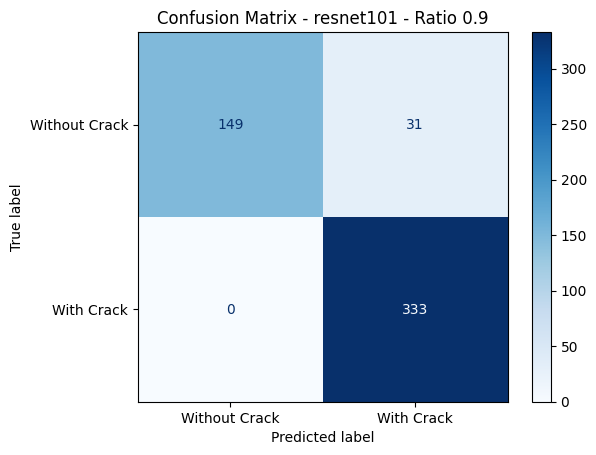

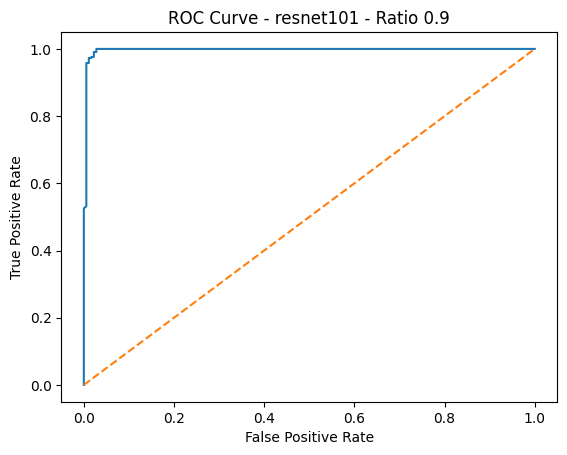

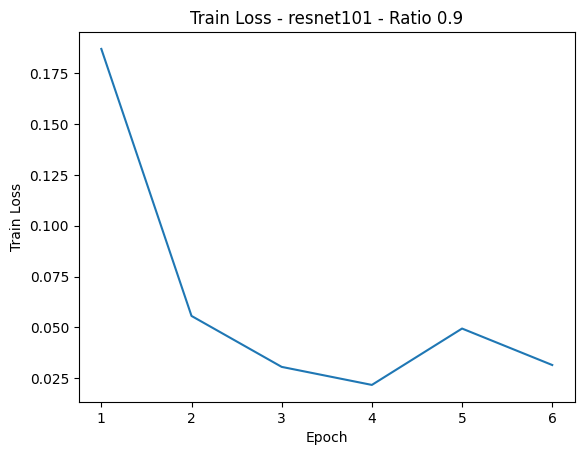

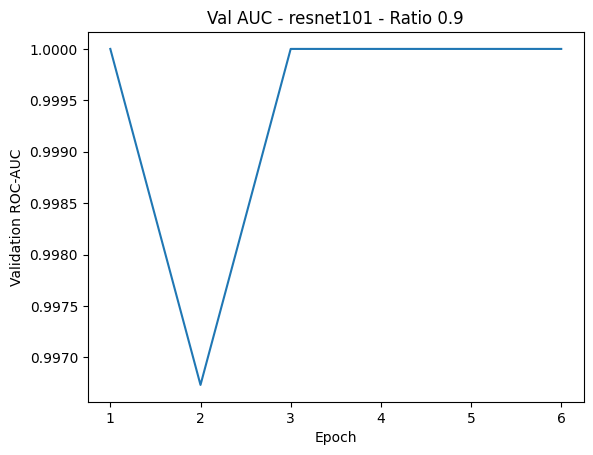

In [23]:
generate_confusion_and_class_accuracy(model, test_loader, best_model, best_ratio)
generate_roc_curve(model, test_loader, best_model, best_ratio)
plot_learning_curves(best_row["learning_logs"], best_model, best_ratio)